## import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


2024-10-01 19:38:50.829020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 19:38:50.829077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 19:38:50.830547: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
basepath='/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image'
categories=['Lung_Opacity','Normal','Viral Pneumonia']

## Set Constants

In [3]:
IMG_SIZE=200
BATCH_SIZE=32
Epochs=45

## Show Some Samples!

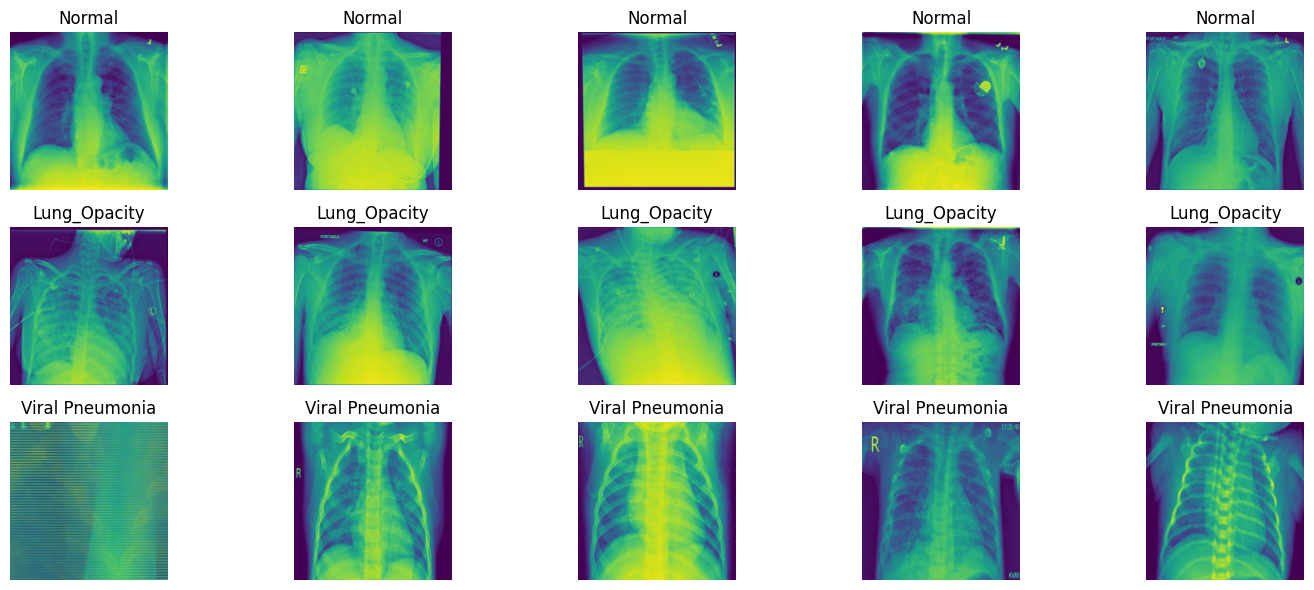

In [4]:
fig, axes = plt.subplots(3, 5, figsize=(15, 6))
axes = axes.flatten()
index=0
# Iterate over categories
for category in (os.listdir(basepath)):
    if index >= 15:
          break  # Only display 10 images
    categoryfolder = os.path.join(basepath, category)
    images = os.listdir(categoryfolder)
    for j in range(5):
      # Select a random image from the category
      imgname = np.random.choice(images)
      imgpath = os.path.join(categoryfolder, imgname)
      image_pil = Image.open(imgpath)
      resized_image = image_pil.resize((IMG_SIZE,IMG_SIZE))
      #image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)  # Convert to RGB
      #print( newarr_img.shape)
      axes[index].imshow(resized_image)
      axes[index].set_title(category)
      axes[index].axis('off')
      index += 1

      if index >= 15:
          break  # Only display 10 images

plt.tight_layout()
plt.show()


## Create Training data!

In [5]:
df=pd.DataFrame(columns=['img_url','label'])
def create_train_data():
    training_data=[]
      #iterate over categories folder
    for category in os.listdir(basepath):
        categoryfolder=os.path.join(basepath,category)

          #iterate over the images and add it to test list
        for img in os.listdir(categoryfolder):
                imgpath=os.path.join(categoryfolder,img)
                image_arr=cv2.imread(imgpath)
                newarr_img=cv2.resize(image_arr,(IMG_SIZE,IMG_SIZE))
                label=categories.index(category)
                training_data.append([newarr_img,label])
                df.loc[len(df)]=[imgpath,category]
                #plt.imshow(image_arr)



    return training_data

In [6]:
train_data=create_train_data()

In [7]:
df.head(1500)

,img_url,label
0,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
1,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
2,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
3,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
4,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
...,...,...
1495,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Lung_Opacity
1496,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Lung_Opacity
1497,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Lung_Opacity
1498,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Lung_Opacity


<Axes: xlabel='label'>

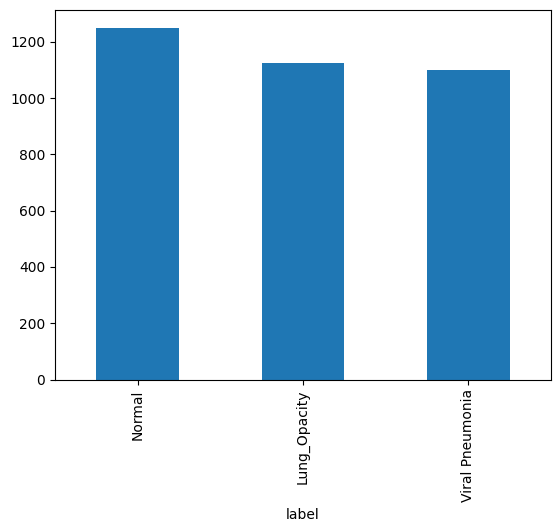

In [8]:
labels_distribution=df['label'].value_counts()
labels_distribution.plot(kind='bar')

## Split Training,validation and test

In [9]:
train_df,test_df=train_test_split(df,test_size=0.2,random_state=42,stratify=df.label)
test_df,val_df=train_test_split(test_df,test_size=0.1,random_state=42,stratify=test_df.label)

In [10]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(2780, 2)
(625, 2)
(70, 2)


In [11]:
train_datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1/255.)

val_datagen  = ImageDataGenerator(rescale=1/255.)
train_generator = train_datagen.flow_from_dataframe(dataframe= train_df,x_col="img_url",y_col="label",
                                      target_size=(IMG_SIZE,IMG_SIZE),

                                      class_mode="categorical",
                                      batch_size=BATCH_SIZE,

                                     )

val_generator = val_datagen.flow_from_dataframe(dataframe= val_df,x_col="img_url",y_col="label",
                                      target_size=(IMG_SIZE,IMG_SIZE),

                                      class_mode="categorical",
                                      batch_size=BATCH_SIZE,
                                      shuffle=False
                                     )

test_generator = test_datagen.flow_from_dataframe(dataframe= test_df,x_col="img_url",y_col="label",
                                      target_size=(IMG_SIZE,IMG_SIZE),

                                      class_mode="categorical",
                                      batch_size=BATCH_SIZE,
                                      shuffle=False
                                     )

Found 2780 validated image filenames belonging to 3 classes.
Found 70 validated image filenames belonging to 3 classes.
Found 625 validated image filenames belonging to 3 classes.


In [12]:
resize_scaling = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

## Build CNN model!

In [13]:
model=keras.models.Sequential([
    keras.layers.Conv2D(32,kernel_size=(3,3),input_shape=(IMG_SIZE,IMG_SIZE,3),activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32,kernel_size=(3,3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    
    keras.layers.Flatten(),

    keras.layers.Dense(128,activation='relu'),

    keras.layers.Dense(3,activation='softmax')


])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16928)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,166,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,186,691 (8.34 MB)

 Trainable params: 2,186,691 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history=model.fit(train_generator,validation_data=val_generator,epochs=Epochs,batch_size=BATCH_SIZE)
                  

Epoch 1/45


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-01 19:39:08.906267: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65: 5.41783, expected 4.72242
2024-10-01 19:39:08.906329: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 66: 4.33458, expected 3.63917
2024-10-01 19:39:08.906339: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 141: 5.05684, expected 4.36143
2024-10-01 19:39:08.906347: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 142: 5.83136, expected 5.13595
2024-10-01 19:39:08.906355: E external/local_xla/xla/service/gpu/buffer_comparator

 4/87 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.2734 - loss: 1.8676

I0000 00:00:1727811552.304116     811 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/87 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5630 - loss: 1.0415

2024-10-01 19:39:15.958233: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 7.51565, expected 6.567
2024-10-01 19:39:15.958300: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 7.29082, expected 6.34217
2024-10-01 19:39:15.958310: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.32147, expected 5.37282
2024-10-01 19:39:15.958318: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 7.55042, expected 6.60177
2024-10-01 19:39:15.958325: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 7.95223, expected 7.00358
2024-10-01 19:39:15.958333: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.55428, expected 6.60563
2024-10-01 19:39:15.958341: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.94057, expected 5.99192
2024-10-01 19:39:15.958348: E external/local_xla/xla/serv

84/87 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6310 - loss: 0.8781

2024-10-01 19:39:22.000051: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 39255: 4.98585, expected 4.37094
2024-10-01 19:39:22.000108: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 39269: 4.56411, expected 3.94921
2024-10-01 19:39:22.000117: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 39270: 4.39198, expected 3.77708
2024-10-01 19:39:22.000125: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 39286: 5.1367, expected 4.52179
2024-10-01 19:39:22.000133: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 39345: 4.36959, expected 3.75469
2024-10-01 19:39:22.000141: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 39385: 5.00712, expected 4.39222
2024-10-01 19:39:22.000149: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 39543: 3.93001, expected 3.31511
2024-10-01 19:39:22.000157: 

87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.6363 - loss: 0.8654 - val_accuracy: 0.7857 - val_loss: 0.5565
Epoch 2/45
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8434 - loss: 0.3801 - val_accuracy: 0.8286 - val_loss: 0.4510
Epoch 3/45
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8514 - loss: 0.3389 - val_accuracy: 0.8429 - val_loss: 0.3511
Epoch 4/45
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8651 - loss: 0.3175 - val_accuracy: 0.8143 - val_loss: 0.3967
Epoch 5/45
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9042 - loss: 0.2478 - val_accuracy: 0.8571 - val_loss: 0.3844
Epoch 6/45
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8963 - loss: 0.2378 - val_accuracy: 0.8714 - val_loss: 0.2707
Epoch 7/45
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9098 - loss: 0.2242 - val_accuracy: 0.8286 - val_loss: 0.3782
Epoch 8/45
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9256 - loss: 0.2071 - val_accuracy: 0.8286 - val_loss: 

In [16]:
val,acc=model.evaluate(train_generator)

87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9434 - loss: 0.1704


In [17]:
val,acc=model.evaluate(test_generator)


19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8707 - loss: 1.5704

2024-10-01 19:43:32.143243: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.16135, expected 5.38987
2024-10-01 19:43:32.143301: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 6.43195, expected 5.66048
2024-10-01 19:43:32.143310: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 6.58687, expected 5.81539
2024-10-01 19:43:32.143318: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65: 6.18307, expected 5.4116
2024-10-01 19:43:32.143326: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 66: 5.10715, expected 4.33567
2024-10-01 19:43:32.143334: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 67: 5.19282, expected 4.42134
2024-10-01 19:43:32.143342: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 73: 6.25262, expected 5.48115
2024-10-01 19:43:32.143349: E external/local_xla/x

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.8699 - loss: 1.5839


##Predict the images!

In [18]:
true_value=test_generator.classes
pred=model.predict(test_generator)
pred=np.argmax(model.predict(test_generator),axis=1)
pred_class_name=[categories[p] for p in pred]
pred_class_name

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


['Viral Pneumonia',
 'Viral Pneumonia',
 'Viral Pneumonia',
 'Lung_Opacity',
 'Normal',
 'Viral Pneumonia',
 'Normal',
 'Viral Pneumonia',
 'Viral Pneumonia',
 'Normal',
 'Viral Pneumonia',
 'Viral Pneumonia',
 'Viral Pneumonia',
 'Normal',
 'Viral Pneumonia',
 'Normal',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Viral Pneumonia',
 'Normal',
 'Normal',
 'Normal',
 'Viral Pneumonia',
 'Normal',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Normal',
 'Viral Pneumonia',
 'Normal',
 'Lung_Opacity',
 'Lung_Opacity',
 'Normal',
 'Normal',
 'Viral Pneumonia',
 'Normal',
 'Normal',
 'Normal',
 'Lung_Opacity',
 'Viral Pneumonia',
 'Viral Pneumonia',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Lung_Opacity',
 'Normal',
 'Viral Pneumonia',
 'Normal',
 'Viral Pneumonia',
 'Lung_Opacity',
 'Normal',
 'Lung_Opacity',
 'Lung_Opacity',
 'Viral Pneumonia',
 'Lung_Opacity',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Lung_Opacity',
 'Viral Pneumonia',
 'Normal',
 'Normal',
 'Lung_Op

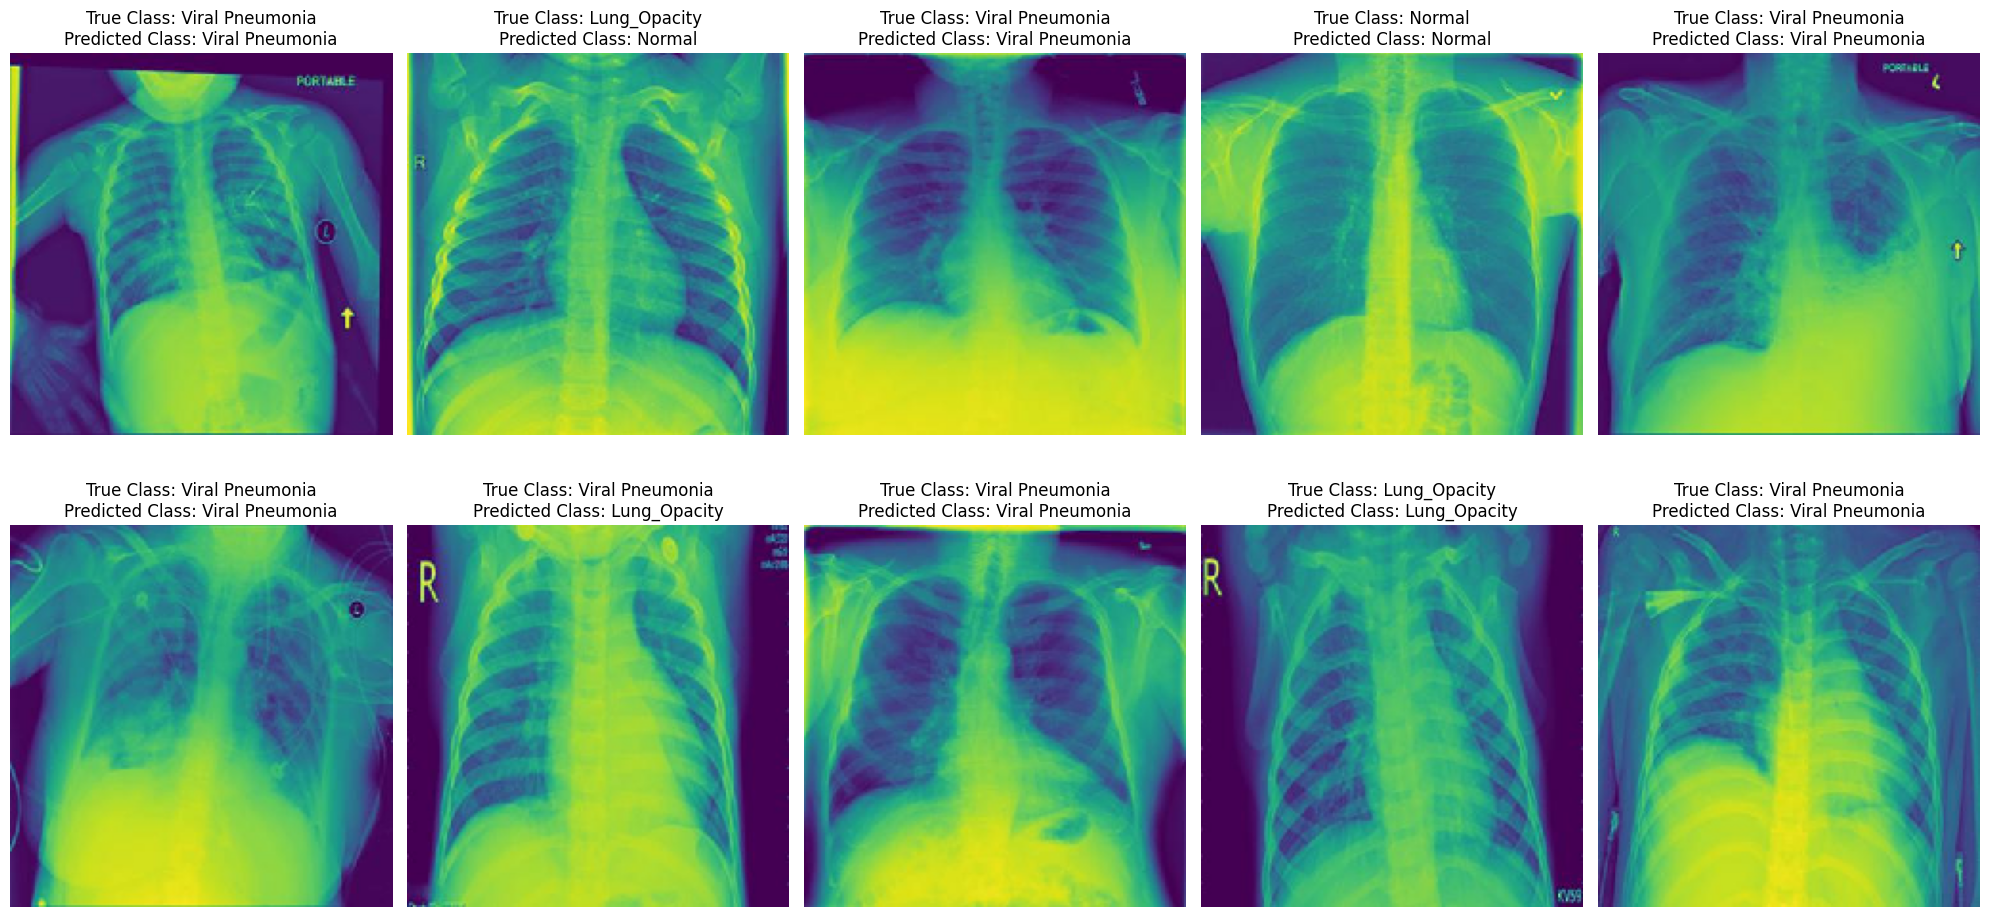

In [19]:
plt.figure(figsize=(20, 10))

random_indices = np.random.choice(len(test_generator), size=10, replace=False)

# Plot true labels and predicted labels side by side
for idx, i in enumerate(random_indices):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(test_generator[i][0][0])  # Display the first image of the batch
    plt.title(f"True Class: {categories[true_value[i]]}\nPredicted Class: {pred_class_name[i]}")
    plt.axis('off')


plt.tight_layout()
plt.show()

In [20]:
print(confusion_matrix(true_value,pred))

[[139  59   4]
 [  9 210   6]
 [  6   2 190]]


In [21]:
# Save the model in HDF5 format
model.save('lung_cancer_model.h5')